# Apology Transformer



In [ ]:
!pip install convokit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.2/183.2 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.1/677.1 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.4/300.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.1 MB/s eta 0:00:00
  Created wheel for convokit: filename=convokit-3.0.0-py3-none-any.whl size=216707 sha256=08e38a1ca1f858fbdcddc1d6aa3e718dd8875a9723118520dc79a07c684967fc
  Stored in directory: /root/.cache/pip/wheels/c4/89/8c/2677fdb888588b6f93cb6ac86bdfb020f1f1c3

In [ ]:
import convokit
from convokit import Corpus, download
from convokit.transformer import Transformer
from inspect import signature
import string
import re
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter

In [ ]:
corpus = Corpus(filename=download("conversations-gone-awry-cmv-corpus"))

No configuration file found at /root/.convokit/config.yml; writing with contents: 
# Default Backend Parameters
db_host: localhost:27017
data_directory: ~/.convokit/saved-corpora
default_backend: mem


In [ ]:
def remove_quotes(comment):
    quoted_pattern = r'&gt;.*?$'
    comment = re.sub(quoted_pattern, '', comment, flags=re.MULTILINE)
    return comment

In [ ]:
apology_list = ['sorry', 'apologize', 'apologies', 'oops', 'whoops', 'woops', 'forgive me', 'forgive my', 'excuse me', 'excuse my', 'my mistake', 'my bad']
first_person = ['i', 'me', 'my', 'myself', 'mine']
second_person = ['you', 'your', 'u', 'ur', 'yours', 'yourself', 'urself']
clarification = ['mean', 'meant', 'clarify','clear','clarification','explain','understand','confused','confusing','what','context','worded','wording','are you','do you','talking about','referring','rephrase','reword','intend','intent','term']
contradictory = ['but','however','while','although']
disagreement = ['wrong','incorrect','inaccurate','false','mistaken','error','bad','nonsensical','stupid','disagree','dumb','bullshit','bs','insufficient','hypocritical','break it']
agreement = ['right','correct','sense','true','accurate','case','work','agree']
negatives = ['no','not','don\'t','dont','doesn\'t','doesnt', 'isn\'t', 'isnt']
wrongdoing = ['regret','mistake','misunderstand','misunderstood','fault','offend','hurt','misread','misspoke','wrong','incorrect','accident','misconception','truly','genuine','sincere']
potential = ['for','if','because','that','about']
requests = ['could','would','can']

In [ ]:
apology_pattern = r"\b(" + "|".join(re.escape(word) for word in apology_list) + r")\b"

clarify_pattern = r"\b(" + "|".join(re.escape(word) for word in clarification) + r")\b"
contradictory_pattern = fr"{apology_pattern}(.{{0,20}}(?:but|however|while|although))\b"
disagree_pattern = r"\b(" + "|".join(re.escape(word) for word in disagreement) + r")\b"
negatives_pattern = r"\b(" + "|".join(re.escape(word) for word in negatives) + r")\b"
agreement_pattern = r"\b(" + "|".join(re.escape(word) for word in agreement) + r")\b"
not_agree_pattern = fr"{negatives_pattern}.{{0,10}}{agreement_pattern}"
potential_pattern = fr"{apology_pattern}.{{0,3}}\b(" + "|".join(re.escape(word) for word in potential) + r")\b"
first_person_pattern = r"\b(" + "|".join(re.escape(word) for word in first_person) + r")\b"
second_person_pattern = r"\b(" + "|".join(re.escape(word) for word in second_person) + r")\b"
wrong_pattern = r"\b(" + "|".join(re.escape(word) for word in wrongdoing) + r")\b"
wrongdoing_pattern = fr"{first_person_pattern}.{{0,10}}{wrong_pattern}"
ask_pattern = r"\b(" + "|".join(re.escape(word) for word in requests) + r")\b"
requests_pattern = fr"({ask_pattern}.{{0,10}}{second_person_pattern})|please"

In [ ]:
class ApologyLabeler(Transformer):
    """
    A transformer to label the diffferent types of apologies in the CMV corpus.
    """

    def __init__(
        self,
        obj_type='utterance',
        output_field='apology_type',
        input_field=None,
        input_filter=None,
        verbosity=10000,
    ):
        if input_filter:
            if len(signature(input_filter).parameters) == 1:
                self.input_filter = lambda utt: input_filter(utt)
            else:
                self.input_filter = input_filter
        else:
            self.input_filter = lambda utt: True
        self.obj_type = obj_type
        self.input_field = input_field
        self.output_field = output_field
        self.verbosity = verbosity

    def _print_output(self, i):
        return (self.verbosity > 0) and (i > 0) and (i % self.verbosity == 0)

    def transform(self, corpus: Corpus) -> Corpus:

        if self.obj_type == 'utterance':
          total = len(list(corpus.iter_utterances()))

          for idx, utterance in enumerate(corpus.iter_utterances()):
              if self._print_output(idx):
                  print(f"%03d/%03d {self.obj_type} processed" % (idx, total))

              text = remove_quotes(utterance.text)
              text = text.lower()
              sentences = re.split(r'(?<=[.!?])\s+', text)

              apology = False
              apology_loc = 0
              for i, sentence in enumerate(sentences):
                apology_match = re.search(apology_pattern, sentence) #start index of match
                if apology_match:
                  apology_loc = apology_match.span()[0]
                  apology_sentence = sentence.strip()
                  next_sentence = " "
                  if (i != len(sentences)-1):
                    next_sentence = sentences[i+1].strip()

                  apology_segment = apology_sentence + next_sentence
                  apology = True

              if apology:

                  pattern_meta_mapping = [
                      (clarify_pattern, 'clarifying_apology'),
                      (potential_pattern, 'wrongdoing_apology'),
                      (wrongdoing_pattern, 'wrongdoing_apology'),
                      (contradictory_pattern, 'disagree_apology'),
                      (disagree_pattern, 'disagree_apology'),
                      (not_agree_pattern, 'disagree_apology'),
                      (requests_pattern, 'request_apology')
                  ]

                  closest_match = min(
                      [(re.search(pattern, apology_segment), meta) for pattern, meta in pattern_meta_mapping if re.search(pattern, apology_segment)],
                      key=lambda x: abs(x[0].start() - apology_loc),
                      default=None
                  )

                  if closest_match:
                      _, meta = closest_match
                      utterance.add_meta(self.output_field, meta)
                  else:
                      utterance.add_meta(self.output_field, 'other_apology')

              else:
                utterance.add_meta(self.output_field, 'no_apology')


In [ ]:
apologizer = ApologyLabeler()
apologizer.transform(corpus)

10000/42964 utterance processed
20000/42964 utterance processed
30000/42964 utterance processed
40000/42964 utterance processed


Sorting Apologies by Types and storing IDs in lists

In [ ]:
apology_ids = []

clarifying_ids = []
disagree_ids = []
wrongdoing_ids = []
request_ids = []
other_ids = []

for utt_id in corpus.get_utterance_ids():
  if corpus.get_utterance(utt_id).meta['apology_type'] != 'no_apology':

    apology_ids.append(utt_id)

    if corpus.get_utterance(utt_id).meta['apology_type'] == 'clarifying_apology':
      clarifying_ids.append(utt_id)

    if corpus.get_utterance(utt_id).meta['apology_type'] == 'disagree_apology':
      disagree_ids.append(utt_id)

    if corpus.get_utterance(utt_id).meta['apology_type'] == 'wrongdoing_apology':
      wrongdoing_ids.append(utt_id)

    if corpus.get_utterance(utt_id).meta['apology_type'] == 'request_apology':
      request_ids.append(utt_id)

    if corpus.get_utterance(utt_id).meta['apology_type'] == 'other_apology':
      other_ids.append(utt_id)

Total Number of identified apologies

In [ ]:
len(apology_ids)

822

Number of apologies by type

In [ ]:
apology_dict = {'clarifying': len(clarifying_ids), 'disagree': len(disagree_ids), 'wrongdoing': len(wrongdoing_ids), 'request': len(request_ids), 'other': len(other_ids)}
print(apology_dict)

{'clarifying': 102, 'disagree': 213, 'wrongdoing': 259, 'request': 26, 'other': 222}


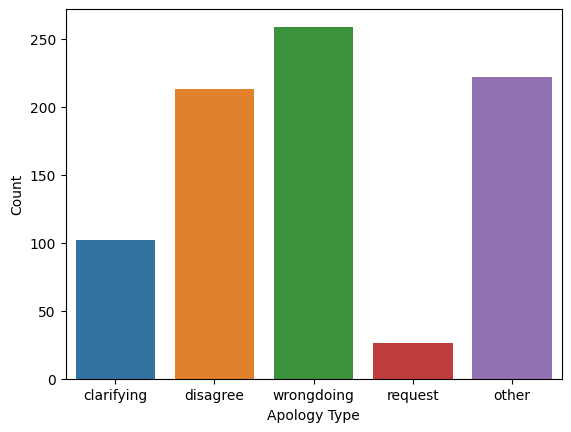

In [ ]:
df = pd.DataFrame(list(apology_dict.items()), columns=['Apology Type', 'Count'])

sns.barplot(x='Apology Type', y='Count', data=df)
plt.show()

Printing out some examples

In [ ]:
# clarifying apology
corpus.get_utterance(clarifying_ids[0]).text

# Sorry, I meant...

'Sorry, I meant "life-long" monogamy in the case of a single partner, not switching them every couple of months.\n\n&gt;Personally I think humans are just plain diverse when it comes to relationships.\n\nAre we though? I don\'t want to be pretentious, but aren\'t we all biologically wired the same? Values/traditions have an impact of course, but in the developed western nations those are usually disregarded when you see a nice piece of aaaaaaaaaaaaaasssshhh and have a shot of alcohol near you.\n\n&gt;An answer to what? What, exactly, is the problem here?\n\nThe problem is that we live in societies that tell us that we have to get married, that people want to get married and that marriage is happiness, when everything points to the contrary.'

In [ ]:
# disagree apology
corpus.get_utterance(disagree_ids[56]).text

# I'm sorry but ...

"&gt;Deleting comments that go against the grain of latestagecapitalism, and banning those that challenge the moderators. It's hard to see how this isn't 'classic' communism, as in best traditions of most communist/socialist regimes that have risen in the past with repression against political dissidents.\n\nIf this is your definition of communism, then I guess you will have to throw /the_Donald into the commie bucket as well. They have long deleted comments, banned users, and supported bots the reproduce without comment (propaganda?). I'm sorry but moderating a sub to a include what you want it to include, isn't communism so much as just an echo chamber. Lots of people like echo chambers and it does nothing to push a communist agenda."

In [ ]:
# wrongdoing apology
corpus.get_utterance(wrongdoing_ids[23]).text

# I truly apologize and don't mean to ...

"I truly apologize and don't mean to hurt your feelings. What I said was in the matter of discussion and debate and within the context I understand that it can be hurtful. I'm sorry that it came off in that manner and I hope you're feelings aren't too hurt. I'm speaking of things on a macro level and happened to use autism as an example and I understand how speaking in such generalities loses the personal touch of humanity. I would just like to say that if an argument like this came up in real life I would refrain from saying such things as everything has a time and place and context. This sub was just meant for what I suppose controversial opinions and I thought this would be a good platform to voice it. I knew what I stated would offend/hurt some people and I truly am sorry and I know you probably don't believe me but that's the best way I can explain it."

In [ ]:
# request apology
corpus.get_utterance(request_ids[17]).text

# I'm sorry you...can you explain...

"I'm sorry you feel that way, can you explain how you perceive it as racist? "